# Notebook para geração das figuras no relatório final

Danilo Lessa Bernardineli

## Dependências e definições

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib
import pandas as pd
import pylab
import scipy
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Tamanho das figuras em polegadas
pylab.rcParams['figure.figsize'] = (20, 10)

# Constantes
satellite_sources = ["goes", "modis-terra", "modis-aqua"]

data_dir = os.path.expanduser("~/dados-ic/output")

path_list = {"goes": "goes.csv",
             "modis-terra": "mod.csv",
             "modis-aqua": "myd.csv",
             "tsi": "tsi.csv",
             "rad-long": "rad.csv",
             "rad-long-longwave": "rad.csv",
             "rad-xl": "rad.csv",
             "rad-xl-corr": "rad.csv"}

cf_list = {"rad-long": "Long_SW_CloudFraction",
           "rad-long-longwave": "Long_LW_CloudFraction",
           "rad-xl" : "XL_CloudFraction",
           "rad-xl-corr": "XL_CloudFractionCorrected",
           "tsi": "TSI_CloudFraction",
           "goes": "CloudFraction_VIS",
           "modis-aqua": "Cloud_Fraction",
           "modis-terra": "Cloud_Fraction"}

## Funções comuns

In [3]:
def load_datasets(name1, name2):
    """
    Carrega datasets correlacionados
    """
    
    if (name1 == name2):
        return
            
    if (name1 not in satellite_sources) and (name2 not in satellite_sources):
        hasSat = False
        if (name1 == "tsi"):
            path = os.path.join(data_dir, path_list[name1][:-4] + "-centered-" + path_list[name2])
        elif ("rad" in name1) and ("rad" in name2):
            path = os.path.join(data_dir, "rad.csv")
        else:
            path = os.path.join(data_dir, path_list[name2][:-4] + "-centered-" + path_list[name1]) 
        ds = pd.read_csv(path, na_values=["--"], parse_dates=["Time"])
    else:
        hasSat = True
        
        _name1 = name1
        _name2 = name2
        
        if (_name1 not in satellite_sources):
            _name1 = name2
            _name2 = name1                 
        if (_name2 == "goes"):
            _name2 = _name1
            _name1 = "goes"
            
        if ("modis" in _name2):
            __name1 = _name1
            _name1 = _name2
            _name2 = __name1
            
        path1 = os.path.join(data_dir, path_list[_name1])
        path2 = os.path.join(data_dir, path_list[_name2])
        path2 = path2[:-4] + "-centered-" + path_list[_name1]
        ds1 = pd.read_csv(path1, na_values=["--"], parse_dates=["Time"])
        ds2 = pd.read_csv(path2, na_values=["--"], parse_dates=["Time"])
        ds = pd.merge(ds1, ds2, on="Time", how="outer")
    
    return {"Dataset": ds, "hasSat": hasSat}


def analyze(dataset, name1, name2, plot=False, output_file=""):
    try:
        ds = dataset["Dataset"]
        col1 = cf_list[name1]
        col2 = cf_list[name2]

        data3 = ds.copy()
        ind = np.isfinite(data3[col1])
        ind &= np.isfinite(data3[col2])
        data3 = data3[ind]

        if not dataset["hasSat"]:
            if ("rad" in name1) and ("rad" in name2):
                return None
            else:
                filter_col = "Timedelta"
                timedeltas = np.unique(data3.Timedelta)
                qtd_timedeltas = len(timedeltas)
                mtr = np.zeros((qtd_timedeltas))
                p_mtr = np.zeros((qtd_timedeltas))
                n_mtr = np.zeros((qtd_timedeltas))
                i = 0
                for timedelta in timedeltas:
                    data4 = data3[data3[filter_col] == timedelta]
                    y1 = data4[col1]
                    y2 = data4[col2]

                    inds = np.isfinite(y2)
                    inds &= np.isfinite(y1)

                    y1 = y1[inds]
                    y2 = y2[inds]
                    (r, p) = st.pearsonr(y1, y2)
                    mtr[i] = r
                    n_mtr[i] = len(y1)
                    i += 1

                gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
                ax1 = plt.subplot(gs[0])
                ax2 = plt.subplot(gs[1])
                ax1.plot(timedeltas / 60, mtr, 'o')
                ax1.set_title("Correlação entre %s e %s" % (name1, name2))
                ax1.set_xlabel("Tempo de amostragem (minutos)")
                ax1.set_ylabel("Coeficiente de correlação de Pearson")
                data3_hours = data3.Time.dt.hour
                ax2.hist(data3_hours, bins=24, range=(0, 24), label="Quantidade de combinações de dados")
                ax2.axvline(22, color='k', label="Intervalo entre 10h e 22h UTC")
                ax2.axvline(10, color='k')
                ax2.set_xlim((0, 24))
                ax2.set_title("Histograma das horas dos dados combinados")
                ax2.set_ylabel("Quantidade")
                ax2.set_xlabel("Horas (UTC)")
                ax2.legend()
                if output_file is not "":
                    plt.savefig(output_file, odpi=300)
                if plot is True:
                    plt.show()
                plt.clf()
        else:
            delta_col = "Delta"
            filter_col = "Timedelta"

            fix_delta_goes = True
            delta_goes = 0.5

            # Filtrar NaNs
            y1 = data3[col1]
            y2 = data3[col2]
            inds = np.isfinite(y1)
            inds &= np.isfinite(y2)
            data3 = data3[inds]

            if (name1 == "goes"):
                delta_col = "Delta_x"
                if (fix_delta_goes is True):
                    inds = data3["Delta_y"] == delta_goes
                    data3 = data3[inds]

            timedeltas = sorted(np.unique(data3[filter_col]))
            deltas = sorted(np.unique(data3[delta_col]))

            qtd_deltas = len(deltas)
            qtd_timedeltas = len(timedeltas)

            mtr = np.zeros((qtd_timedeltas, qtd_deltas))
            p_mtr = np.zeros((qtd_timedeltas, qtd_deltas))
            n_mtr = np.zeros((qtd_timedeltas, qtd_deltas))
            i = 0
            j = 0
            for timedelta in timedeltas:
                for delta in deltas:

                    data4 = data3[data3[delta_col] == delta]
                    data4 = data4[data4[filter_col] == timedelta]
                    y1 = data4[col1]
                    y2 = data4[col2]

                    inds = np.isfinite(y2)
                    inds &= np.isfinite(y1)
                    #inds &= y1 < 0.99
                    #inds &= y2 < 0.99

                    y1 = y1[inds]
                    y2 = y2[inds]
                    (r, p) = st.pearsonr(y1, y2)
                    mtr[i, j] = r
                    n_mtr[i, j] = len(y1)
                    p_mtr[i, j] = p
                    #mtr[i, j] = len(y1)
                    j += 1
                j = 0
                i += 1

            gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
            plot_mtr = mtr
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])        
            mp = ax1.matshow(plot_mtr, aspect="auto")
            ax1.set_xlabel("Tamanho da caixa espacial em graus")    
            xticks = np.arange(len(deltas))
            xticklabels = ["{:.1f}".format(it) for it in deltas]
            ax1.set_xticks(xticks)
            ax1.set_xticklabels(xticklabels)
            ax1.set_ylabel("Tamanho da caixa temporal em minutos")        
            yticks = np.arange(len(timedeltas))
            yticklabels = ["{:.0f}".format(it / 60) for it in timedeltas]
            ax1.set_yticks(yticks)
            ax1.set_yticklabels(yticklabels)
            CS = ax1.contour(xticks, yticks, plot_mtr, colors="k")        
            plt.colorbar(mp, label="Coeficiente de Correlação de Pearson", ax=ax1)
            ax1.set_title("Correlação entre %s e %s" % (name1, name2))
            for (i, j), z in np.ndenumerate(plot_mtr):
                ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=10)
            data3_hours = data3.Time.dt.hour
            ax2.hist(data3_hours, bins=24, range=(0, 24), label="Quantidade de combinações de dados")
            ax2.axvline(22, color='k', label="Intervalo entre 10h e 22h UTC")
            ax2.axvline(10, color='k')
            ax2.set_xlim((0, 24))
            ax2.set_title("Histograma das horas dos dados combinados")
            ax2.set_ylabel("Quantidade")
            ax2.set_xlabel("Horas (UTC)")
            ax2.legend()
            if output_file != "":
                plt.savefig(output_file, odpi=300)
            if plot is True:
                plt.show()
            plt.clf()
        return mtr
    except:
        return None


### Ver graficamente as correlações entre diferentes amostragens

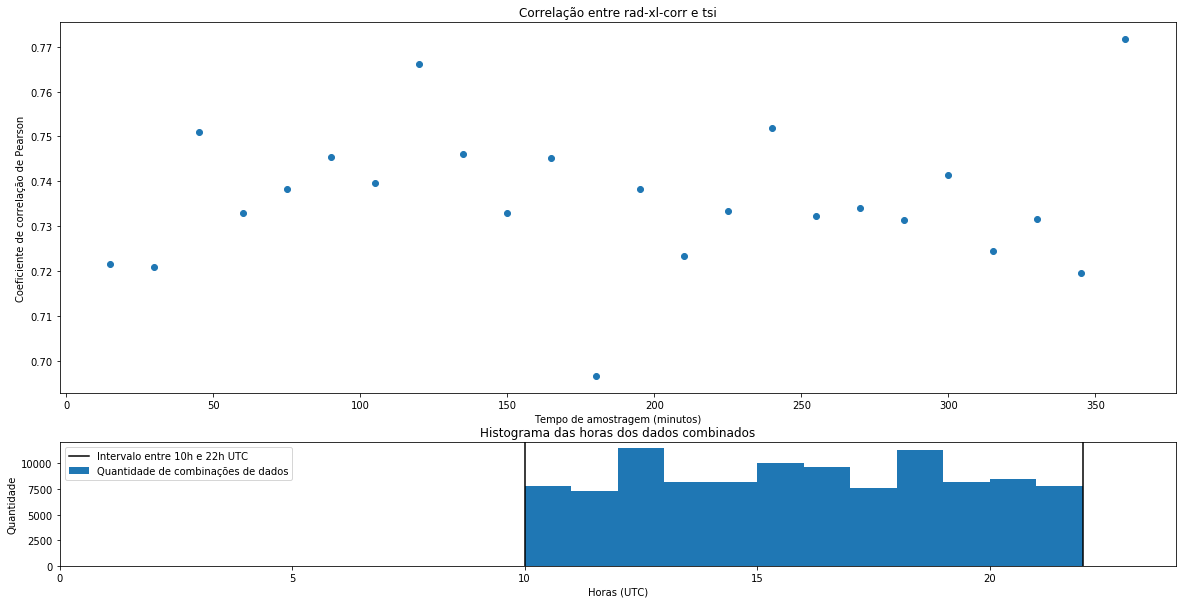

In [6]:
name1 = "rad-xl-corr"
name2 = "tsi"

ds = load_datasets(name1, name2)

data = ds["Dataset"] 
ind1 = data.Time.dt.hour >= 10
ind1 &= data.Time.dt.hour < 22
ds["Dataset"] = data[ind1]

a = analyze(ds, name1, name2, True)
plt.show()

### Fazer uma matriz com os máximos de correlação para cada janela

In [7]:
def plot_max_corr(name1, name2, plot=True, save=False):
    try:
            if ("rad" in name1) and ("rad" in name2):
                return None
            data_mtr = np.ones((12, 12))
            data_mtr = data_mtr * np.nan

            proc_count = 0
            total_count = np.sum(np.arange(13))

            for i in range(12):
                for j in range(12  - i):
                    print("\r%s/%s" % (proc_count, total_count), end="" )
                    ds = load_datasets(name1, name2)
                    data = ds["Dataset"]         
                    ind1 = data.Time.dt.hour >= (i + 10)
                    ind1 &= data.Time.dt.hour < (j + 11 + i)
                    ds["Dataset"] = data[ind1]
                    output_file = "imgs/{}_{}_[{}-{}].png".format(name1, name2, 10+i, 11+j+i)
                    a = analyze(ds, name1, name2, False, output_file)
                    data_mtr[i, j] = np.max(a)
                    proc_count += 1    


            ax1 = plt.subplot()
            mp = ax1.matshow(data_mtr)

            for (i, j), z in np.ndenumerate(data_mtr):
                ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=10)

            plt.title("Correlação máxima entre as amostragens espaço-temporais (%s, %s)" % (name1, name2))

            ax1.set_xticks(np.arange(12))
            ax1.set_xticklabels(np.arange(1, 13))
            ax1.set_xlabel("Duração da janela (h)")

            ax1.set_yticks(np.arange(12))
            ax1.set_yticklabels(np.arange(10, 23))
            ax1.set_ylabel("Horário do ínicio da combinação (UTC)")
            plt.colorbar(mp, label="Correlação máxima")
            if save:
                plt.savefig("imgs/max_{}_{}.png".format(name1, name2))
            if plot:
                plt.show()
            plt.clf()
    except:
            return None

In [8]:
cf_sources = list(cf_list.keys())
qtd_cf_sources = len(cf_sources)

for i in range(0, qtd_cf_sources):
    cf1 = cf_sources[i]
    for j in range(i+1, qtd_cf_sources):
        cf2 = cf_sources[j]
        print("Processando {} x {}".format(cf1, cf2))
        plot_max_corr(cf1, cf2, False, True)
    

Processando rad-long x rad-long-longwave
Processando rad-long x rad-xl
Processando rad-long x rad-xl-corr
Processando rad-long x tsi
77/78Processando rad-long x goes
77/78Processando rad-long x modis-aqua
0/78

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


77/78Processando rad-long x modis-terra
77/78Processando rad-long-longwave x rad-xl
Processando rad-long-longwave x rad-xl-corr
Processando rad-long-longwave x tsi
77/78Processando rad-long-longwave x goes
77/78Processando rad-long-longwave x modis-aqua
77/78Processando rad-long-longwave x modis-terra
77/78Processando rad-xl x rad-xl-corr
Processando rad-xl x tsi
77/78Processando rad-xl x goes
77/78Processando rad-xl x modis-aqua
77/78Processando rad-xl x modis-terra
77/78Processando rad-xl-corr x tsi
77/78Processando rad-xl-corr x goes
77/78Processando rad-xl-corr x modis-aqua
77/78Processando rad-xl-corr x modis-terra
77/78Processando tsi x goes
77/78Processando tsi x modis-aqua
77/78Processando tsi x modis-terra
77/78Processando goes x modis-aqua
77/78Processando goes x modis-terra
77/78Processando modis-aqua x modis-terra
0/78

In [9]:
col1 = "Cloud_Fraction"
col2 = "TSI_CloudFraction"

inds = np.isfinite(data[col1])
inds &= np.isfinite(data[col2])
#inds &= data[col1] < 1
#inds &= data[col2] < 1
d = data[inds]

f = lambda x, a, b, c, d: a * x ** 2 + b * x + c + d * x ** 3

#out = scipy.optimize.curve_fit(f, d[col1], d[col2], p0=[0, 0, 0, 0])

#x = np.linspace(0, 1, 50)
#y = f(x, *out[0])
#plt.errorbar(x, y)
plt.hist2d(d[col1], d[col2], bins=100, range=((0, 0.9), (0, 0.9)))
plt.colorbar()

plt.show()

KeyError: 'Cloud_Fraction'

In [70]:
out[0]

array([-0.58218947,  1.46099988, -0.00647603])